In [24]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [25]:
#here we are creating a chatbot with the external tool using langgraph
##first query will go to the chatbot if it is able to answer or else it will go to the external tool
#chatbot will interact with LLM and external tool
from typing import Annotated
from typing_extensions import TypedDict #use this two in the state class to manage the state


In [26]:
!pip install arxiv wikipedia

In [27]:
# work with external tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

#call the external tools
arxiv = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv)

wikipedia = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia)



In [28]:
wikipedia_tool.invoke("who is germany chancellor?")

'Page: Chancellor of Germany\nSummary: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elect'

In [29]:
arxiv_tool.invoke("what is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from'

In [30]:
tool=[wikipedia_tool, arxiv_tool]



In [31]:
#langgraph application

from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list,add_messages] #add messages to the state

In [32]:
from langgraph.graph import StateGraph,START,END


In [33]:
graph_builder = StateGraph(State) # state is going to be used to manage the state of the graph


In [34]:
from dotenv import load_dotenv
load_dotenv()
import os   
groq_api_key = os.getenv("GROQ_API_KEY") # get the groq api key from the environment variable

from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x11ede2f10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11ee396d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [35]:
llm_with_tools=llm.bind_tools(tools=tool) # bind the tools to the llm

In [36]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]} # invoke the llm with the last message in the state)

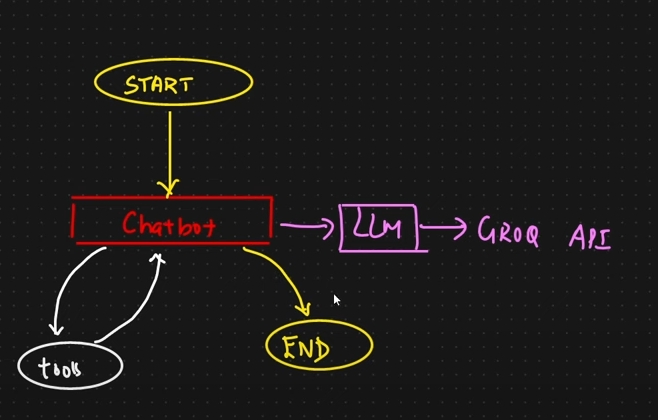
This is the flow we are trying to achieve

In [37]:
from langgraph.prebuilt import ToolNode,tools_condition

In [38]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot") # add the edge from start to chatbot

In [39]:
tool_node=ToolNode(tools=tool) # add the tool node to the graph
graph_builder.add_node("tools",tool_node) # add the tool node to the graph
graph_builder.add_conditional_edges("chatbot",
                                    tools_condition)# add the conditional edges to the graph becuase the chatbot will invoke the tool if it is not able to answer the query

In [40]:
#tools need to reconnect to the chatbot
graph_builder.add_edge("tools", "chatbot") # add the edge from tool to chatbot
graph_builder.add_edge("chatbot", END) # add the edge from chatbot to end

In [41]:
graph=graph_builder.compile()

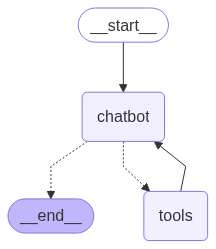

In [42]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [44]:
user_input="Hi there!, My name is subitha, I am a software engineer. Can you tell me about the latest research on quantum computing?"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is subitha, I am a software engineer. Can you tell me about the latest research on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_gn4c)
 Call ID: call_gn4c
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: arxiv

Published: 2022-08-01
Title: The Rise of Quantum Internet Computing
Authors: Seng W. Loke
Summary: This article highlights quantum Internet computing as referring to
distributed quantum computing over the quantum Internet, analogous to
(classical) Internet computing involving (classical) distributed
================================== Ai Message ==================================

Quantum Internet computing is a new field that is developing rapidly. It involves distributed quantum computing over a network, similar to how classic

In [45]:
user_input="Hi there!, My name is subitha, who is the actor in the movie inception?"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is subitha, who is the actor in the movie inception?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_cx2h)
 Call ID: call_cx2h
  Args:
    query: Inception (film)
================================= Tool Message =================================
Name: wikipedia

Page: Inception
Summary: Inception is a 2010 science fiction  action  heist film written and directed by Christopher Nolan, who also produced it with Emma Thomas, his wife. The film stars Leonardo DiCaprio as a professional thief who steals information by infiltrating the subconscious of his targets
================================== Ai Message ==================================

Leonardo DiCaprio
